# EigenFaces 

PB20061210 赖永凡

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

NUM_SUBJECTS = 40 
NUM_IMAGES = 9 # Using the last face picture for testing
IMAGE_SIZE = (112, 92) 
NUM_EIGENFACES = 25 

## Plot sampled subjects

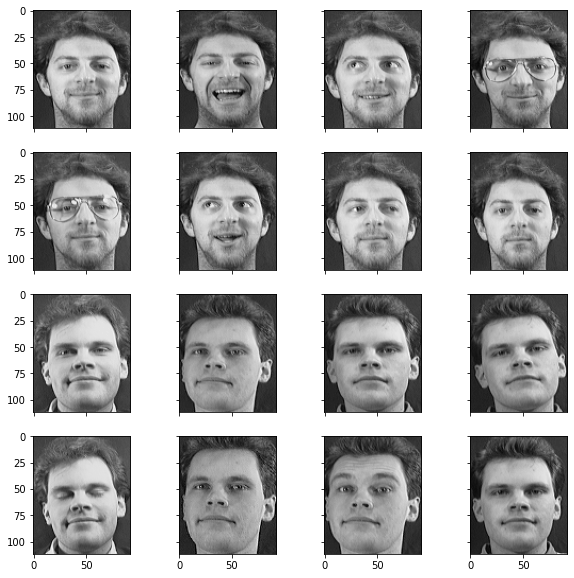

In [2]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
num = 0
for i in [7, 36]:
    for j in range(8):
        img_root = os.path.join('./images', f's{i}/{j + 1}.pgm')
        face = cv2.imread(img_root, cv2.IMREAD_GRAYSCALE)
        axes[num//4][num%4].imshow(face, cmap="gray")
        num += 1
plt.show()

## Data input & Eigenfaces funtion

In [3]:
def load_dataset():
    print('Loading dataset...')
    # Initialize an empty array to store all the images
    images = np.empty((NUM_SUBJECTS * NUM_IMAGES, IMAGE_SIZE[0] * IMAGE_SIZE[1]), dtype=np.uint8)
    # Initialize an empty array to store all the labels
    labels = np.empty((NUM_SUBJECTS * NUM_IMAGES), dtype=np.int32)

    for i in range(NUM_SUBJECTS):
        folder = f"s{i+1}"
        for j in range(NUM_IMAGES):
            file = f"{j+1}.pgm"
            path = os.path.join("images", folder, file)

            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            image = image.flatten()

            images[i * NUM_IMAGES + j] = image
            labels[i * NUM_IMAGES + j] = i + 1

    return images, labels


def compute_eigenfaces(images):
    print('Computing eigenfaces...')
    mean_face = np.mean(images, axis=0)
    centered_images = images - mean_face # NUM_IMAGES x IMAGE_SIZE[0] * IMAGE_SIZE[1]

    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(centered_images @ centered_images.T)
    eigenvectors = centered_images.T @ eigenvectors

    # Normalization
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

    # Sort the eigenvalues and eigenvectors in descending order of eigenvalue magnitude
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]


    # Select the top k eigenvectors as eigenfaces
    k = min(NUM_EIGENFACES, len(eigenvalues))
    eigenfaces = eigenvectors[:, :k]

    # Project each centered image onto the eigenface space
    projections = np.dot(centered_images, eigenfaces)
    return mean_face, eigenfaces, projections


def train():
    images, labels = load_dataset()
    mean_face, eigenfaces, projections = compute_eigenfaces(images)
    model = {"mean_face": mean_face, "eigenfaces": eigenfaces, "projections": projections, "labels": labels}
    return model


def test(model, image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.flatten()

    centered_image = image - model["mean_face"]
    projection = np.dot(centered_image, model["eigenfaces"])

    distances = np.linalg.norm(model["projections"] - projection, axis=1)
    nearest_idx = np.argmin(distances)
    nearest_label = model["labels"][nearest_idx]
    nearest_distance = distances[nearest_idx]

    return nearest_label, nearest_distance


## Experiment

In [4]:
# Training phase
model = train()

Loading dataset...
Computing eigenfaces...


In [5]:
# Test an unseen image and print its predicted label and distance 
acc = 0
dist = 0
for i in range(NUM_SUBJECTS):
    label, distance = test(model, f"./images/s{i + 1}/10.pgm")
    acc += (i + 1 == label)
    dist += distance

print(f"Predicted acc: {acc / NUM_SUBJECTS}")
print(f"Mean Distance: {dist / NUM_SUBJECTS}")

Predicted acc: 0.925
Mean Distance: 1112.633007263945


## Model analysis & Visualization

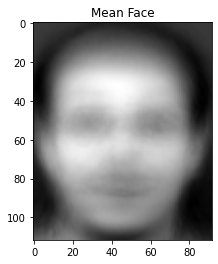

In [6]:
# Plot mean face
plt.imshow(model['mean_face'].reshape(IMAGE_SIZE), cmap="gray")
plt.title("Mean Face")
plt.show()

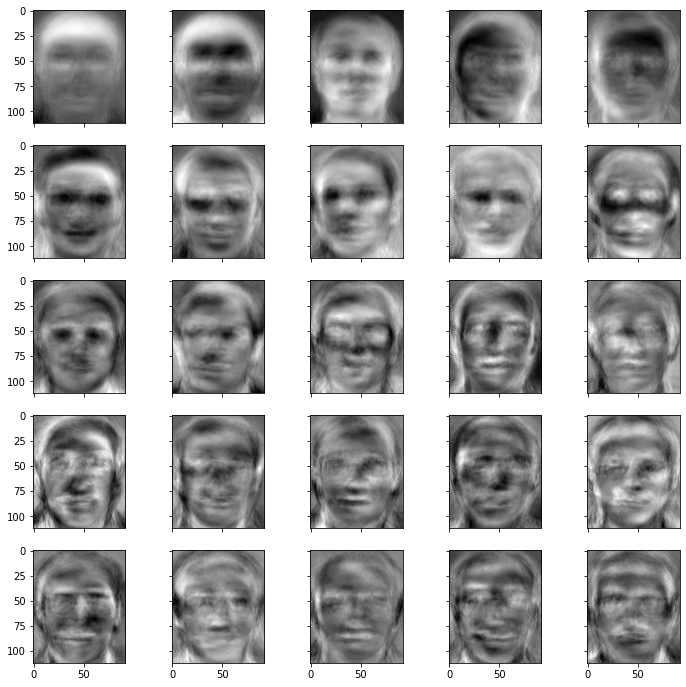

In [7]:
# Plot eigen faces
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,12))
num = 0
for j in range(25):
    ef = model['eigenfaces'][:, j].reshape(IMAGE_SIZE)
    axes[num//5][num%5].imshow(ef, cmap="gray")
    num += 1

plt.show()